In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from end2end_script import get_cost

%load_ext autoreload
%autoreload 2

# Gather

In [3]:
df = pd.DataFrame()
for i in range(0,9):
    df = pd.concat([df,pd.read_csv(f"./out/collection/pareto_raw,{i},2024-12-15,batch_size=500.csv")])
# df = pd.read_csv("./out/collection/expand_simulation,2024-11-26,num_circuits=100000.csv")
df

,Unnamed: 0,strong_id,decoder,json_metadata,shots,errors,discards,seconds,custom_counts,d,e,p,r,d2,erasure_post_rate,id
0,0,1619325e6987ca937fd4d2791c95ff419d393ab85c4953...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, ...",1000,2,81,20.822727,Counter(),3,0.00,0.0010,2,9,1.000000e+00,28
1,1,6ee7b2d355c5533f74ebdba73fa61155d127e7b1130369...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, ...",1000,2,68,21.891177,Counter(),3,0.00,0.0010,2,9,1.000000e+00,17
2,2,bbf75ab96b2a58a190e0f1616a45009220af2a035a7ef0...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, ...",1000,0,71,21.926703,Counter(),3,0.00,0.0010,2,9,1.000000e+00,0
3,3,0b16703e28d6edc948195d9beceaeeef0fd8b7175fd73a...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, ...",1000,2,72,21.891980,Counter(),3,0.00,0.0010,2,9,1.000000e+00,18
4,4,9102bc93721a4fbe5375aebf029de5729177f796e61d45...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, ...",1000,0,73,19.037876,Counter(),3,0.00,0.0010,2,9,1.000000e+00,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,f87ae7a976ff88b12beb6a53bf02762da2137fc4b9283f...,pymatching,"{'d': 7, 'e': 0.01, 'p': 0.0001, 'r': 4, 'd2':...",1000,0,107,0.228148,Counter(),7,0.01,0.0001,4,9,2.077995e-08,4990
299996,299996,a338e3a9e27732d67079e6bf1eef9852628b547ed497b2...,pymatching,"{'d': 7, 'e': 0.01, 'p': 0.0001, 'r': 4, 'd2':...",1000,0,100,0.266914,Counter(),7,0.01,0.0001,4,9,2.077995e-08,4983
299997,299997,df9dd9af2788a1f3ea180dbfc44e4e4ef8e2bf59b2cbeb...,pymatching,"{'d': 7, 'e': 0.01, 'p': 0.0001, 'r': 4, 'd2':...",1000,0,100,0.303371,Counter(),7,0.01,0.0001,4,9,2.077995e-08,4979
299998,299998,45882e6f735497d243abab0443b3aad33c9c3ba58e8da3...,pymatching,"{'d': 7, 'e': 0.01, 'p': 0.0001, 'r': 4, 'd2':...",1000,0,112,0.194622,Counter(),7,0.01,0.0001,4,9,2.077995e-08,4998


In [4]:
import ast
metadata = ast.literal_eval(df['json_metadata'].iloc[0])  # from string to dict
df['json_metadata'] = df['json_metadata'].apply(lambda d: ast.literal_eval(d))
df['json_metadata'].apply(lambda d: d.pop('id', None))  # Since dict is mutable, we can modify it in place
df['json_metadata'] = df['json_metadata'].astype(str)
df['error_rate_per_circuit'] = df['errors'] / (df['shots'] - df['discards'])
df['var_per_circuit'] = df['error_rate_per_circuit'] * (1-df['error_rate_per_circuit']) / (df['shots'] - df['discards'])

df_grouped = df.groupby('json_metadata').agg({'shots': 'sum', 'errors': 'sum', 'discards': 'sum', 'seconds': 'sum',
                                              'decoder': 'first', 'var_per_circuit': 'mean', 'error_rate_per_circuit': 'var'} 
                                            | {key: 'first' for key in metadata.keys()})

df.groupby('json_metadata').agg({
    'shots': 'sum',
    'errors': 'sum',
    'discards': 'sum',
    'seconds': 'sum',
    'decoder': 'first',
    'var_per_circuit': 'mean',
    'error_rate_per_circuit': 'var',
    'strong_id': 'count',
} | {key: 'first' for key in metadata.keys()})
df_grouped = df_grouped.rename(columns={'error_rate_per_circuit': 'Var(E(X|Y))', 'var_per_circuit': 'E(Var(Y|X))', 'strong_id': 'num_circuits'})
df_grouped['success_rate'] = 1 - df_grouped['discards'] / df_grouped['shots']
df_grouped['error_rate'] = df_grouped['errors'] / (df_grouped['shots'] - df_grouped['discards'])
# df_grouped['total_var'] = df_grouped['E(Var(Y|X))']/10000 + df_grouped['Var(E(X|Y))'].fillna(0)
df_grouped['total_var'] = df_grouped.error_rate * (1-df_grouped.error_rate) / df_grouped['shots'] + df_grouped['Var(E(X|Y))'].fillna(0) / 100_000
df_grouped['qubit_rounds_cost'] = get_cost(df_grouped['d'], df_grouped['r'], df_grouped['success_rate']) / df_grouped['erasure_post_rate']

df_grouped

,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y)),d,e,p,r,d2,erasure_post_rate,id,success_rate,error_rate,total_var,qubit_rounds_cost
json_metadata,,,,,,,,,,,,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, 'erasure_post_rate': 1}",45000000,46054,3401304,37112.634546,pymatching,1.195003e-06,1.196093e-06,3,0.000,0.0010,2,9,1.000000e+00,28,0.924415,0.001107,3.653596e-11,3.678000e+01
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 3, 'd2': 9, 'erasure_post_rate': 1}",45000000,44089,5026527,36121.485828,pymatching,1.239172e-06,1.244409e-06,3,0.000,0.0010,3,9,1.000000e+00,2,0.888299,0.001103,3.692720e-11,5.741307e+01
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 4, 'd2': 9, 'erasure_post_rate': 1}",45000000,42364,6588487,36059.277535,pymatching,1.289687e-06,1.288264e-06,3,0.000,0.0010,4,9,1.000000e+00,23,0.853589,0.001103,3.736447e-11,7.966362e+01
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'd2': 9, 'erasure_post_rate': 0.8755827330125209}",45000000,2781,351304,36339.696417,pymatching,6.269370e-08,8.958692e-08,3,0.001,0.0001,2,9,8.755827e-01,13,0.992193,0.000062,2.279922e-12,3.913681e+01
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 3, 'd2': 9, 'erasure_post_rate': 0.8198796317393}",45000000,2829,529874,36621.455229,pymatching,6.427935e-08,9.454109e-08,3,0.001,0.0001,3,9,8.198796e-01,0,0.988225,0.000064,2.359004e-12,6.294543e+01
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 4, 'd2': 9, 'erasure_post_rate': 0.7677202681101272}",45000000,3296,705625,36738.513569,pymatching,6.962924e-08,5.967918e-06,3,0.001,0.0001,4,9,7.677203e-01,1,0.984319,0.000074,6.133264e-11,8.998494e+01
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 2, 'd2': 9, 'erasure_post_rate': 0.5872807797426924}",45000000,11738,352739,37153.235787,pymatching,2.377464e-07,2.710326e-05,3,0.004,0.0001,2,9,5.872808e-01,11,0.992161,0.000263,2.768734e-10,5.835134e+01
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 3, 'd2': 9, 'erasure_post_rate': 0.45132527300317016}",45000000,10008,529962,37169.899149,pymatching,2.158518e-07,1.169884e-05,3,0.004,0.0001,3,9,4.513253e-01,3,0.988223,0.000225,1.219884e-10,1.143472e+02
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 4, 'd2': 9, 'erasure_post_rate': 0.3468434675158815}",45000000,9869,705425,38121.923530,pymatching,2.148902e-07,1.151448e-05,3,0.004,0.0001,4,9,3.468435e-01,5,0.984324,0.000223,1.200949e-10,1.991762e+02


# Plot

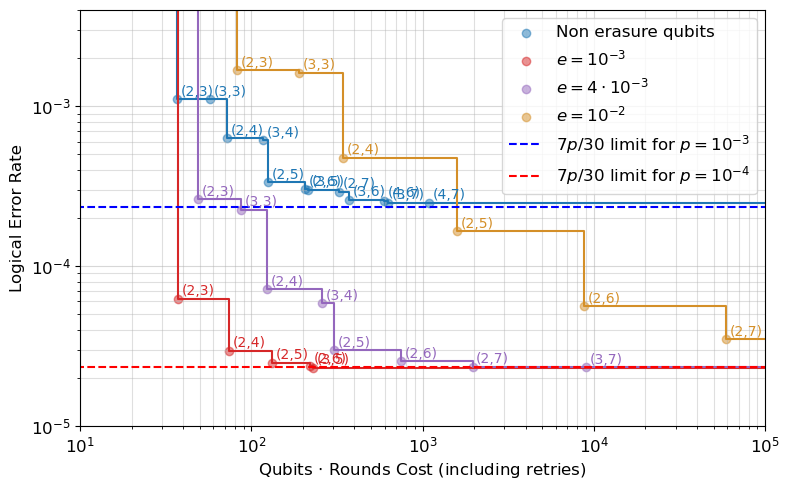

In [68]:
# fig, axes = plt.subplots(2, 1, figsize=(6, 6))
from datetime import date
from itertools import cycle
from matplotlib import rcParams
rcParams['font.family'] = 'DejaVu Sans'

label_fontsize = 12
title_fontsize = 12
legend_fontsize = 10
annotate_fonsize = 10

# colors = ['b','orange','g','r']
colors = ['#1f77b4',  # Blue
          '#d62728',  # Red
          '#9467bd',  # Purple
          # '#ff7f0e',  # Orange
          '#d48f28',  # Medium-Dark Orange
          # '#2ca02c',  # Green
         ]
# colors = ['#2c73b3',  # Medium-Dark Blue
#           '#c1573b',  # Medium-Dark Red
#           '#7d3c98',  # Medium-Dark Purple
#           '#d48f28',  # Medium-Dark Orange
#          ]

color_generator = cycle(colors)

e_label_dict = {
    0: 'Non erasure qubits',
    1e-3: '$e=10^{-3}$',
    4e-3: '$e=4 \\cdot 10^{-3}$',
    1e-2: '$e=10^{-2}$',
}

# Assuming df_grouped is your original DataFrame
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Iterate over unique values of parameter 'e'
for e_value in df_grouped['e'].unique():
    # Filter the DataFrame for the current value of 'e'
    df_filtered = df_grouped[df_grouped['e'] == e_value]
    color = next(color_generator)
    
    # Sort by cost and then by error rate
    df_sorted = df_filtered.sort_values(by=['qubit_rounds_cost', 'error_rate'], ascending=[True, True])

    # Determine Pareto front
    pareto_front = []
    current_error_rate = np.inf
    for _, row in df_sorted.iterrows():
        if row['error_rate'] < current_error_rate:
            pareto_front.append(row)
            current_error_rate = row['error_rate']
            ax.scatter(row['qubit_rounds_cost'], row['error_rate'], label=e_label_dict[e_value], alpha=0.5, color = color)
            ax.annotate(
                f'({row["r"]},{row["d"]})',
                (row["qubit_rounds_cost"]*1.05, row["error_rate"]*1.05),
                color=color,
                fontsize = annotate_fonsize,
            )

    pareto_front_df = pd.DataFrame(pareto_front)

    # Extract horizontal-then-vertical Pareto front points
    # pareto_x = [pareto_front_df.iloc[0]['qubit_rounds_cost']]
    # pareto_y = [pareto_front_df.iloc[0]['error_rate']]
    pareto_x = [1]
    pareto_y = [1]
    for i in range(0, len(pareto_front_df)):
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_y[-1])  # Horizontal segment
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_front_df.iloc[i]['error_rate'])  # Vertical segment
    pareto_y.append(pareto_y[-1])
    pareto_x.append(1e6)

    # Plot the scatter points and Pareto front for the current value of 'e'
    # label = 'Non erasure qubits' if e_value==0 else f'$e=10^{{{np.log10(e_value):.0f}}}$'
    # ax.scatter(df_filtered['qubit_rounds_cost'], df_filtered['error_rate'], label=e_label_dict[e_value], alpha=0.5, cmap = color)
    ax.plot(pareto_x, pareto_y, linestyle='-', marker=None, color=color) #label=f'Pareto front e={e_value}' , p={df_sorted.iloc[0].p}

# Annotate all points
# for i, row in df_grouped.iterrows():
    # ax.annotate(f'({row["r"]},{row["d"]})', (row["qubit_rounds_cost"]*1.05, row["error_rate"]*1.05), color=color)

p = 1e-3
ax.hlines(7*p/30, 0, 1e6, colors='b', linestyles='dashed', label='$7p/30$ limit for $p=10^{-3}$')
p = 1e-4
ax.hlines(7*p/30, 0, 1e6, colors='r', linestyles='dashed', label='$7p/30$ limit for $p=10^{-4}$')

# ax.annotate("$(d_1,r)$", (1e3,5e-4), fontsize = 14)

ax.set_xlim(10,1e5)
ax.set_ylim(1e-5,4e-3)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Logical Error Rate', fontsize = label_fontsize)
ax.set_xlabel('Qubits $\\cdot$ Rounds Cost (including retries)', fontsize = label_fontsize)
# ax.set_title('Pareto Curve for Error Rate vs Cost', fontsize= title_fontsize)
ax.grid(which='major', alpha=0.5)
ax.grid(which='minor', alpha=0.4)

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates by using a dictionary
ax.legend(by_label.values(), by_label.keys(), fontsize = label_fontsize)

# ax.legend(fontsize = label_fontsize)
ax.tick_params(labelsize=label_fontsize)
fig.tight_layout()
plt.savefig(f'./out/figures/{date.today()}-end2end.svg')
plt.show()

# Cursed addition of $d_2=9$

In [10]:
df_d2_is_9 = pd.read_csv('./out/collection/erasure_simulations,2024-10-27,num_circuits=5000,d2=9.csv')
df_d2_is_9

,json_metadata,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y)),d,e,p,r,d2,erasure_post_rate,error_rate,success_rate,qubit_rounds_cost
0,"{'d': 3, 'e': 0.002, 'p': 0.0001, 'r': 2, 'd2'...",5000000,2116,70292,1012.837695,pymatching,4.358946e-07,5.071512e-05,3,0.002,0.0001,2,9,0.643753,0.000429,0.985942,53.568396
1,"{'d': 3, 'e': 0.002, 'p': 0.0001, 'r': 3, 'd2'...",5000000,2590,106373,914.309162,pymatching,5.419401e-07,1.048918e-04,3,0.002,0.0001,3,9,0.516510,0.000529,0.978725,100.885951
2,"{'d': 5, 'e': 0.002, 'p': 0.0001, 'r': 2, 'd2'...",5000000,289,198689,936.263513,pymatching,6.262936e-08,6.685140e-08,5,0.002,0.0001,2,9,0.279914,0.000060,0.960262,364.596070
3,"{'d': 5, 'e': 0.002, 'p': 0.0001, 'r': 3, 'd2'...",5000000,285,295685,962.228872,pymatching,6.434539e-08,6.517636e-08,5,0.002,0.0001,3,9,0.148094,0.000061,0.940863,1055.005094
4,"{'d': 7, 'e': 0.002, 'p': 0.0001, 'r': 2, 'd2'...",5000000,249,383590,952.323417,pymatching,5.847541e-08,6.123501e-08,7,0.002,0.0001,2,9,0.080257,0.000054,0.923282,2618.094625
5,"{'d': 7, 'e': 0.002, 'p': 0.0001, 'r': 3, 'd2'...",5000000,225,565647,1042.684340,pymatching,5.732487e-08,5.578643e-08,7,0.002,0.0001,3,9,0.022736,0.000051,0.886871,14431.440984


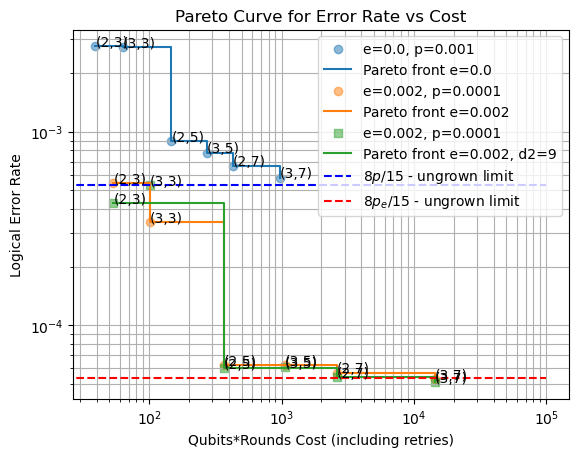

In [15]:


# Assuming df_grouped is your original DataFrame
fig, ax = plt.subplots(1, 1)

# Iterate over unique values of parameter 'e'
for e_value in df_grouped['e'].unique():
    # Filter the DataFrame for the current value of 'e'
    df_filtered = df_grouped[df_grouped['e'] == e_value]
    
    # Sort by cost and then by error rate
    df_sorted = df_filtered.sort_values(by=['qubit_rounds_cost', 'error_rate'], ascending=[True, True])

    # Determine Pareto front
    pareto_front = []
    current_error_rate = np.inf
    for _, row in df_sorted.iterrows():
        if row['error_rate'] < current_error_rate:
            pareto_front.append(row)
            current_error_rate = row['error_rate']

    pareto_front_df = pd.DataFrame(pareto_front)

    # Extract horizontal-then-vertical Pareto front points
    pareto_x = [pareto_front_df.iloc[0]['qubit_rounds_cost']]
    pareto_y = [pareto_front_df.iloc[0]['error_rate']]
    for i in range(1, len(pareto_front_df)):
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_y[-1])  # Horizontal segment
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_front_df.iloc[i]['error_rate'])  # Vertical segment

    # Plot the scatter points and Pareto front for the current value of 'e'
    ax.scatter(df_filtered['qubit_rounds_cost'], df_filtered['error_rate'], label=f'e={e_value}, p={df_sorted.iloc[0].p}', alpha=0.5)
    ax.plot(pareto_x, pareto_y, linestyle='-', marker=None, label=f'Pareto front e={e_value}')

# Annotate all points
for i, row in df_grouped.iterrows():
    ax.annotate(f'({row["r"]},{row["d"]})', (row["qubit_rounds_cost"], row["error_rate"]))

# Iterate over unique values of parameter 'e'
for e_value in df_d2_is_9['e'].unique():
    # Filter the DataFrame for the current value of 'e'
    df_filtered = df_d2_is_9[df_d2_is_9['e'] == e_value]
    
    # Sort by cost and then by error rate
    df_sorted = df_filtered.sort_values(by=['qubit_rounds_cost', 'error_rate'], ascending=[True, True])

    # Determine Pareto front
    pareto_front = []
    current_error_rate = np.inf
    for _, row in df_sorted.iterrows():
        if row['error_rate'] < current_error_rate:
            pareto_front.append(row)
            current_error_rate = row['error_rate']

    pareto_front_df = pd.DataFrame(pareto_front)

    # Extract horizontal-then-vertical Pareto front points
    pareto_x = [pareto_front_df.iloc[0]['qubit_rounds_cost']]
    pareto_y = [pareto_front_df.iloc[0]['error_rate']]
    for i in range(1, len(pareto_front_df)):
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_y[-1])  # Horizontal segment
        pareto_x.append(pareto_front_df.iloc[i]['qubit_rounds_cost'])
        pareto_y.append(pareto_front_df.iloc[i]['error_rate'])  # Vertical segment

    # Plot the scatter points and Pareto front for the current value of 'e'
    ax.scatter(df_filtered['qubit_rounds_cost'], df_filtered['error_rate'], marker = 's' ,label=f'e={e_value}, p={df_sorted.iloc[0].p}', alpha=0.5)
    ax.plot(pareto_x, pareto_y, linestyle='-', marker=None, label=f'Pareto front e={e_value}, d2=9')

# Annotate all points
for i, row in df_d2_is_9.iterrows():
    ax.annotate(f'({row["r"]},{row["d"]})', (row["qubit_rounds_cost"], row["error_rate"]))


p = 1e-3
ax.hlines(8*p/15, 0, 1e5, colors='b', linestyles='dashed', label='$8p/15$ - ungrown limit')
p = 1e-4
ax.hlines(8*p/15, 0, 1e5, colors='r', linestyles='dashed', label='$8p_e/15$ - ungrown limit')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Logical Error Rate')
ax.set_xlabel('Qubits*Rounds Cost (including retries)')
ax.set_title('Pareto Curve for Error Rate vs Cost')
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
plt.show()

# Calculate error bars

In [2]:
df = pd.read_csv('./out/collection/erasure_simulations_raw,2024-10-21,num_circuits=2000.csv')
df.head()

,Unnamed: 0,strong_id,decoder,json_metadata,shots,errors,discards,seconds,custom_counts,d,e,p,r,erasure_post_rate
0,0,2378bac4dac22109d42414eaca8ec3fd4ed3f6819beacb...,pymatching,"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_...",2000000,4685,264205,1021.633842,Counter(),3,0.000,0.0010,2,1.00000
1,1,1366301391ebe830c4b8cf449019ea2d39608921f749fe...,pymatching,"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'era...",1000,0,12,10.112473,Counter(),3,0.001,0.0001,2,0.80243
2,2,d2c62e2d970b026c6fcdbd33631e3611632abc7adc458b...,pymatching,"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'era...",1000,0,16,10.207786,Counter(),3,0.001,0.0001,2,0.80243
3,3,7735d5ac248bcc29f18784f3a2753c56c2790f4a0f3e07...,pymatching,"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'era...",1000,0,23,10.219560,Counter(),3,0.001,0.0001,2,0.80243
4,4,bdd487eed1e7c12a411b11f6a2c1f7c4a5359d8750b06a...,pymatching,"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'era...",1000,0,12,10.214791,Counter(),3,0.001,0.0001,2,0.80243


In [7]:
df['error_rate_per_circuit'] = df['errors'] / (df['shots'] - df['discards'])
df['var_per_circuit'] = df['error_rate_per_circuit'] / (df['shots'] - df['discards'])

Var(E(Y|X)): 2.9878046588350473e-07
E(Var(Y|X)): 2.0743596031124228e-07


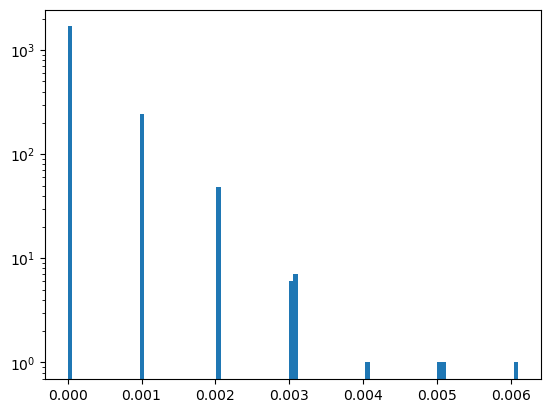

In [28]:
circuit_rates = df.query("e != 0 and d==3 and r==2")['error_rate_per_circuit']
plt.hist(circuit_rates, bins=100)
plt.yscale("log")
print("Var(E(Y|X)):", circuit_rates.var())
print("E(Var(Y|X)):", df.query("e != 0 and d==3 and r==2")['var_per_circuit'].mean())

In [15]:
df['json_metadata'][1]

"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'erasure_post_rate': 0.8024304668606911}"

In [12]:
gr = df.groupby('json_metadata').agg({'shots': 'sum', 'errors': 'sum', 'discards': 'sum', 'seconds': 'sum', 'decoder': 'first', 'var_per_circuit': 'mean', 'error_rate_per_circuit': 'var'})
gr.rename(columns={'error_rate_per_circuit': 'Var(E(X|Y))', 'var_per_circuit': 'E(Var(Y|X))'})

,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y))
json_metadata,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,4685,264205,1021.633842,pymatching,1.554937e-09,NaN
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 3, 'erasure_post_rate': 1}",2000000,4416,388371,947.505200,pymatching,1.700196e-09,NaN
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'erasure_post_rate': 0.8024304668606911}",2000000,403,28480,1106.183616,pymatching,2.074360e-07,2.987805e-07
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 3, 'erasure_post_rate': 0.718805041673813}",2000000,395,42509,990.765087,pymatching,2.061039e-07,3.060977e-07
"{'d': 5, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,1170,667382,959.091018,pymatching,6.588317e-10,NaN
"{'d': 5, 'e': 0, 'p': 0.001, 'r': 3, 'erasure_post_rate': 1}",2000000,903,914058,1074.344871,pymatching,7.657279e-10,NaN
"{'d': 5, 'e': 0.001, 'p': 0.0001, 'r': 2, 'erasure_post_rate': 0.5292373811410899}",2000000,102,79669,963.668725,pymatching,5.544659e-08,5.701105e-08
"{'d': 5, 'e': 0.001, 'p': 0.0001, 'r': 3, 'erasure_post_rate': 0.385013331416238}",2000000,98,118540,995.382667,pymatching,5.528217e-08,5.482186e-08
"{'d': 7, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,670,1099809,996.261399,pymatching,8.268095e-10,NaN


In [10]:
gr

,shots,errors,discards,seconds,decoder,var_per_circuit,error_rate_per_circuit
json_metadata,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,4685,264205,1021.633842,pymatching,1.554937e-09,NaN
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 3, 'erasure_post_rate': 1}",2000000,4416,388371,947.505200,pymatching,1.700196e-09,NaN
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'erasure_post_rate': 0.8024304668606911}",2000000,403,28480,1106.183616,pymatching,2.074360e-07,2.987805e-07
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 3, 'erasure_post_rate': 0.718805041673813}",2000000,395,42509,990.765087,pymatching,2.061039e-07,3.060977e-07
"{'d': 5, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,1170,667382,959.091018,pymatching,6.588317e-10,NaN
"{'d': 5, 'e': 0, 'p': 0.001, 'r': 3, 'erasure_post_rate': 1}",2000000,903,914058,1074.344871,pymatching,7.657279e-10,NaN
"{'d': 5, 'e': 0.001, 'p': 0.0001, 'r': 2, 'erasure_post_rate': 0.5292373811410899}",2000000,102,79669,963.668725,pymatching,5.544659e-08,5.701105e-08
"{'d': 5, 'e': 0.001, 'p': 0.0001, 'r': 3, 'erasure_post_rate': 0.385013331416238}",2000000,98,118540,995.382667,pymatching,5.528217e-08,5.482186e-08
"{'d': 7, 'e': 0, 'p': 0.001, 'r': 2, 'erasure_post_rate': 1}",2000000,670,1099809,996.261399,pymatching,8.268095e-10,NaN


In [23]:
# update post select rate
from expand_script import SparseIdlingNoiseModel
import sys
sys.path.append('./gidney_code/src')
from hookinj._make_circuit import *
from erasure_simulator import *

basis = 'hook_inject_Y'
grown_distance = 15
debug_out_dir = None
memory_rounds = 15
convert_to_cz = False

for index, row in df_grouped.iterrows():
    circ = make_circuit(
        basis=basis,
        distance=grown_distance,
        noise=SparseIdlingNoiseModel.sj_model(p),
        debug_out_dir=debug_out_dir,
        postselected_rounds=row.r,
        postselected_diameter=row.d,
        memory_rounds=memory_rounds,
        convert_to_cz=convert_to_cz,
    )
    e = row.e

    df_grouped.loc[index, 'updated_post_rate'] = get_erasure_post_rate(
        circ, 
        e=1 - (1 - e)**0.5,  # convert to e_star 
        e1=e/10, 
        e_SPAM = e, 
        r=row.r, 
        erasure_post_qubits = get_small_patch_qubits(circ)
    )

df_grouped['qubit_rounds_cost'] = get_cost(df_grouped['d'], df_grouped['r'], df_grouped['success_rate']) / df_grouped['updated_post_rate']    

In [29]:

df_grouped['cost_without_erasure'] = get_cost(df_grouped['d'], df_grouped['r'], df_grouped['success_rate'])




In [30]:
df_grouped

,shots,errors,discards,seconds,decoder,E(Var(Y|X)),Var(E(X|Y)),d,e,p,r,d2,erasure_post_rate,id,success_rate,error_rate,total_var,qubit_rounds_cost,updated_post_rate,cost_without_erasure
json_metadata,,,,,,,,,,,,,,,,,,,,
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 2, 'd2': 9, 'erasure_post_rate': 1}",45000000,46054,3401304,37112.634546,pymatching,1.195003e-06,1.196093e-06,3,0.000,0.0010,2,9,1.000000e+00,28,0.924415,0.001107,3.653596e-11,3.678000e+01,1.000000,36.779999
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 3, 'd2': 9, 'erasure_post_rate': 1}",45000000,44089,5026527,36121.485828,pymatching,1.239172e-06,1.244409e-06,3,0.000,0.0010,3,9,1.000000e+00,2,0.888299,0.001103,3.692720e-11,5.741307e+01,1.000000,57.413075
"{'d': 3, 'e': 0, 'p': 0.001, 'r': 4, 'd2': 9, 'erasure_post_rate': 1}",45000000,42364,6588487,36059.277535,pymatching,1.289687e-06,1.288264e-06,3,0.000,0.0010,4,9,1.000000e+00,23,0.853589,0.001103,3.736447e-11,7.966362e+01,1.000000,79.663615
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 2, 'd2': 9, 'erasure_post_rate': 0.8755827330125209}",45000000,2781,351304,36339.696417,pymatching,6.269370e-08,8.958692e-08,3,0.001,0.0001,2,9,8.755827e-01,13,0.992193,0.000062,2.279922e-12,3.741385e+01,0.915905,34.267518
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 3, 'd2': 9, 'erasure_post_rate': 0.8198796317393}",45000000,2829,529874,36621.455229,pymatching,6.427935e-08,9.454109e-08,3,0.001,0.0001,3,9,8.198796e-01,0,0.988225,0.000064,2.359004e-12,5.874662e+01,0.878479,51.607679
"{'d': 3, 'e': 0.001, 'p': 0.0001, 'r': 4, 'd2': 9, 'erasure_post_rate': 0.7677202681101272}",45000000,3296,705625,36738.513569,pymatching,6.962924e-08,5.967918e-06,3,0.001,0.0001,4,9,7.677203e-01,1,0.984319,0.000074,6.133264e-11,8.198988e+01,0.842583,69.083264
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 2, 'd2': 9, 'erasure_post_rate': 0.5872807797426924}",45000000,11738,352739,37153.235787,pymatching,2.377464e-07,2.710326e-05,3,0.004,0.0001,2,9,5.872808e-01,11,0.992161,0.000263,2.768734e-10,4.872154e+01,0.703357,34.268620
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 3, 'd2': 9, 'erasure_post_rate': 0.45132527300317016}",45000000,10008,529962,37169.899149,pymatching,2.158518e-07,1.169884e-05,3,0.004,0.0001,3,9,4.513253e-01,3,0.988223,0.000225,1.219884e-10,8.672012e+01,0.595107,51.607781
"{'d': 3, 'e': 0.004, 'p': 0.0001, 'r': 4, 'd2': 9, 'erasure_post_rate': 0.3468434675158815}",45000000,9869,705425,38121.923530,pymatching,2.148902e-07,1.151448e-05,3,0.004,0.0001,4,9,3.468435e-01,5,0.984324,0.000223,1.200949e-10,1.372005e+02,0.503518,69.082952


In [21]:
circ = make_circuit(
    basis=basis,
    distance=grown_distance,
    noise=SparseIdlingNoiseModel.sj_model(p),
    debug_out_dir=debug_out_dir,
    postselected_rounds=2,
    postselected_diameter=3,
    memory_rounds=memory_rounds,
    convert_to_cz=convert_to_cz,
)
e = row.e

get_erasure_post_rate(
    circ, 
    e=1 - (1 - e)**0.5,  # convert to e_star 
    e1=e/10, 
    e_SPAM = e, 
    r=2, 
    erasure_post_qubits = get_small_patch_qubits(circ)
)

0.4138143277689276